In [8]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Documents/NFDI4Earth/juliaeoTerceira2023/handson_datacubes`


# Part 1 Understand chunking and rechunking

Task: Use your favorite NetCDF package and method to compute 

a) mean and 
b) median per spatial pixel

for the air_temperature_2m variable in this dataset without loading the whole data into memory (7GB uncompressed data per variable)

We first test access time along different axes:

In [9]:
using NetCDF
using DiskArrays: eachchunk

v = NetCDF.open("esdc_subset2_compressed.nc","layer")

Disk Array with size 1440 x 720 x 1794


In [10]:
@time v[:,:,1];

  0.276003 seconds (916.45 k allocations: 52.513 MiB, 96.88% compilation time)


In [11]:
@time v[1,1,:];

 28.471426 seconds (578.51 k allocations: 30.627 MiB, 0.56% compilation time)


In [6]:
vchunked = NetCDF.open("esdc_subset_compressed.nc","layer")

@time vchunked[:,:,1];

  2.546404 seconds (40 allocations: 3.956 MiB)


In [7]:
@time vchunked[1,1,:];

  0.244399 seconds (38 allocations: 8.672 KiB)


Access along spatial strides is much faster than access of time series
because of the internal storage in the netcdf file

In [8]:

eachchunk(v)

1×1×1794 DiskArrays.GridChunks{3}:
[:, :, 1] =
 (1:1440, 1:720, 1:1)

[:, :, 2] =
 (1:1440, 1:720, 2:2)

[:, :, 3] =
 (1:1440, 1:720, 3:3)

;;; … 

[:, :, 1792] =
 (1:1440, 1:720, 1792:1792)

[:, :, 1793] =
 (1:1440, 1:720, 1793:1793)

[:, :, 1794] =
 (1:1440, 1:720, 1794:1794)


DiskArrays.jl knows about the internal chunking structure and provides special implementations
for mapreduce which is used in the implementation of mean for AbstractArray
The following two aggregations access every chunk only once:


In [48]:

using Statistics
@time mean(v,dims=3)

@time mean(v,dims=(1,2))

 30.839701 seconds (4.71 M allocations: 7.170 GiB, 0.75% gc time, 3.44% compilation time: 0% of which was recompilation)
 28.478390 seconds (700.35 k allocations: 6.962 GiB, 0.47% gc time, 0.57% compilation time)


1×1×1794 Array{Float32, 3}:
[:, :, 1] =
 NaN

[:, :, 2] =
 NaN

[:, :, 3] =
 NaN

;;; … 

[:, :, 1792] =
 277.7125

[:, :, 1793] =
 277.91547

[:, :, 1794] =
 277.78473


This gets more difficult for the median, because here we need the full ts in memory.
This makes it impossible to compute the median in a single pass
Let's try this on a small subset


In [49]:

v2 = view(v,1:2, 1:2,:)
out = zeros(size(v2,1),size(v2,2))

@time for ilat in axes(v2,2), ilon in axes(v2,1)
    out[ilon,ilat] = median(v2[ilon,ilat,:])
end

104.814163 seconds (2.51 M allocations: 139.902 MiB, 0.05% gc time, 0.56% compilation time)



This already takes ages to finish for 4 grid cells only. It would be better to e.g. always read approx 1GB of data at a time and consecutively do the computations:

In [50]:

using ProgressMeter
out = zeros(size(v,1),size(v,2))
latsteps = 90
latranges = [(i*90-latsteps+1):(i*90) for i in 1:(720 ÷ latsteps)]


8-element Vector{UnitRange{Int64}}:
 1:90
 91:180
 181:270
 271:360
 361:450
 451:540
 541:630
 631:720

In [51]:
@showprogress for ilat in latranges
    out[:,ilat] = median(v[:,ilat,:],dims=3)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:39




This finishes in a reasonable amount of time. 
Alternatively we can use YAXArrays.jl which does exactly this workflow for a given cache size


In [8]:
pwd()

"/home/fcremer/Documents/NFDI4Earth/juliaeoTerceira2023/handson_datacubes"

In [14]:
using YAXArrays
ds = open_dataset("esdc_subset_compressed.nc")

ds.layer

LoadError: ArgumentError: Path esdc_subset_compressed.nc is not a directory.

In [55]:
medtair = mapslices(median, ds.layer, dims="Time", max_cache=1e9)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


YAXArray with the following dimensions
lon                 Axis with 1440 Elements from -179.875 to 179.875
lat                 Axis with 720 Elements from 89.875 to -89.875
Total size: 3.96 MB



YAXArrays will also take care of parallelization, for IO-limited processing tasks, we use Distributed.jl 

In [4]:
using Distributed, Zarr
addprocs(4)

4-element Vector{Int64}:
 10
 11
 12
 13

In [5]:
@everywhere begin 
    using Pkg
    Pkg.activate(".")
    Pkg.instantiate()
    #Pkg.status()
    using YAXArrays, Statistics, NetCDF, Zarr
end

  Activating project at `~/Documents/NFDI4Earth/juliaeoTerceira2023/handson_datacubes`


      From worker 13:	  Activating project at `~/Documents/NFDI4Earth/juliaeoTerceira2023/handson_datacubes`
      From worker 10:	  Activating project at `~/Documents/NFDI4Earth/juliaeoTerceira2023/handson_datacubes`
      From worker 11:	  Activating project at `~/Documents/NFDI4Earth/juliaeoTerceira2023/handson_datacubes`
      From worker 12:	  Activating project at `~/Documents/NFDI4Earth/juliaeoTerceira2023/handson_datacubes`


In [6]:
medtair = mapslices(median, ds.layer, dims="Time", max_cache=1e9)

LoadError: UndefVarError: ds not defined

In [3]:
rmprocs(workers())

Task (done) @0x00007fe3b759c5d0

# Avoiding "slow" data access by re-chunking

When repeatedly accessing data in an un-optimal way, rechunking might be an option. For example when you plan to develop some new method and you know that it will have to access the data from the time direction. 

In [80]:
dsrechunked = setchunks(ds,(time=184,lat=90,lon=90))

YAXArray Dataset
Dimensions: 
   lat                 Axis with 720 Elements from 89.875 to -89.875
   lon                 Axis with 1440 Elements from -179.875 to 179.875
   time                Axis with 1748 Elements from 1980-01-05T00:00:00 to 2017-12-31T00:00:00
Variables: air_temperature_2m land_surface_temperature gross_primary_productivity terrestrial_ecosystem_respiration net_ecosystem_exchange 
Properties: date_created => 22.10.2020 chunking => 1x720x1440 creator_email => info@earthsystemdatalab.net keywords => Earth Science, Geophysical Variables time_coverage_end => 31.12.2018 acknowledgment => The ESDL team acknowledges all data providers!  geospatial_resolution => 1/4deg time_coverage_resolution => P8D publisher_email => info@earthsystemdatalab.net time_coverage_duration => P40Y history => Fri Jan  6 14:14:02 2023: ncks -L 1 esdc_subset.nc esdc_subset_compressed.nc
- processing with esdl cube v0.1  (https://github.com/esa-esdl/esdl-core/) time_coverage_start => 05.01.1979 i

In [81]:
savedataset(dsrechunked,path = "esdc_airtemp.zarr", overwrite=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


YAXArray Dataset
Dimensions: 
   lat                 Axis with 720 Elements from 89.875 to -89.875
   lon                 Axis with 1440 Elements from -179.875 to 179.875
   time                Axis with 1748 Elements from 1980-01-05T00:00:00 to 2017-12-31T00:00:00
Variables: air_temperature_2m land_surface_temperature gross_primary_productivity terrestrial_ecosystem_respiration net_ecosystem_exchange 
Properties: date_created => 22.10.2020 chunking => 1x720x1440 creator_email => info@earthsystemdatalab.net keywords => Earth Science, Geophysical Variables time_coverage_end => 31.12.2018 acknowledgment => The ESDL team acknowledges all data providers!  geospatial_resolution => 1/4deg time_coverage_resolution => P8D publisher_email => info@earthsystemdatalab.net time_coverage_duration => P40Y history => Fri Jan  6 14:14:02 2023: ncks -L 1 esdc_subset.nc esdc_subset_compressed.nc
- processing with esdl cube v0.1  (https://github.com/esa-esdl/esdl-core/) time_coverage_start => 05.01.1979 i

Now we have created a new permanent copy of the dataset in zarr format and with relatively large chunks in time. This significantly speeds up computations along the time axis

In [7]:
ds = open_dataset(zopen("esdc_subset2.zarr",fill_as_missing=false))
medtair = mapslices(median, ds.air_temperature_2m, dims="Time", max_cache=1e9)

LoadError: ProcessExitedException(2)

Worker 5 terminated.
Unhandled Task ERROR: EOFError: read end of file
Stacktrace:
 [1] (::Base.var"#wait_locked#680")(s::Sockets.TCPSocket, buf::IOBuffer, nb::Int64)
   @ Base ./stream.jl:945
 [2] unsafe_read(s::Sockets.TCPSocket, p::Ptr{UInt8}, nb::UInt64)
   @ Base ./stream.jl:953
 [3] unsafe_read
   @ ./io.jl:759 [inlined]
 [4] unsafe_read(s::Sockets.TCPSocket, p::Base.RefValue{NTuple{4, Int64}}, n::Int64)
   @ Base ./io.jl:758
 [5] read!
   @ ./io.jl:760 [inlined]
 [6] deserialize_hdr_raw
   @ ~/.julia/juliaup/julia-1.8.4+0.x64.linux.gnu/share/julia/stdlib/v1.8/Distributed/src/messages.jl:167 [inlined]
 [7] message_handler_loop(r_stream::Sockets.TCPSocket, w_stream::Sockets.TCPSocket, incoming::Bool)
   @ Distributed ~/.julia/juliaup/julia-1.8.4+0.x64.linux.gnu/share/julia/stdlib/v1.8/Distributed/src/process_messages.jl:172
 [8] process_tcp_streams(r_stream::Sockets.TCPSocket, w_stream::Sockets.TCPSocket, incoming::Bool)
   @ Distributed ~/.julia/juliaup/julia-1.8.4+0.x64.linux.gnu


# A more complicated example, creating a SAR data cube with time series chunks from GDAL VRTs

@Felix, please add your parts here

We want to combine multiple Tif files into one data cube to then do time series analysis on that.
We use Sentinel-1 data as an example for that. 
    First we look for the .tif files with a given substring in our folder

In [28]:
using Dates
using ArchGDAL: ArchGDAL as AG
using YAXArrays

┌ Info: Precompiling YAXArrays [c21b50f5-aa40-41ea-b809-c0f5e47bfa5c]
└ @ Base loading.jl:1664


In [19]:
folder = "s1data"
pol = "VH"
allfiles = Iterators.flatten([joinpath.((t[1],), t[3]) for t in walkdir(folder)])
nonhiddenfiles = Iterators.filter(x->!startswith(basename(x),"."), allfiles)
filteredfiles = collect(Iterators.filter(x->occursin(pol,x), nonhiddenfiles))


4-element Vector{String}:
 "s1data/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.tif"
 "s1data/S1A__IW___D_20161003T101253_127_VH_grd_mli_norm_geo.tif"
 "s1data/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.tif"
 "s1data/S1A__IW___D_20200116T101309_127_VH_grd_mli_norm_geo.tif"

In [20]:
using Dates
function getdate(x,reg = r"[0-9]{8}T[0-9]{6}", df = dateformat"yyyymmddTHHMMSS")
   m = match(reg,x).match
   date =DateTime(m,df)
end
dates = getdate.(filteredfiles)

4-element Vector{DateTime}:
 2016-10-03T10:12:28
 2016-10-03T10:12:53
 2020-01-16T10:12:44
 2020-01-16T10:13:09

In [21]:
p = sortperm(dates)
sdates = dates[p]
sfiles = filteredfiles[p]


4-element Vector{String}:
 "s1data/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.tif"
 "s1data/S1A__IW___D_20161003T101253_127_VH_grd_mli_norm_geo.tif"
 "s1data/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.tif"
 "s1data/S1A__IW___D_20200116T101309_127_VH_grd_mli_norm_geo.tif"

In [22]:
"""
grouptimes(times, timediff=200000)
Group a sorted vector of time stamps into subgroups
where the difference between neighbouring elements are less than `timediff` milliseconds.
This returns the indices of the subgroups as a vector of vectors.
"""
function grouptimes(times, timediff=200000)
   @assert sort(times) == times
   group = [1]
   groups = [group]

   for i in 2:length(times)
      t = times[i]
      period = t - times[group[end]]
      if period.value < timediff
         push!(group, i)
      else
         push!(groups, [i])
         group = groups[end]
      end
   end
   return groups
end

groupinds = grouptimes(sdates, 200000)


2-element Vector{Vector{Int64}}:
 [1, 2]
 [3, 4]

In [23]:
  tmppaths = [joinpath(tempdir(), splitext(basename(sfiles[group][1]))[1] * ".vrt") for group in groupinds]

2-element Vector{String}:
 "/tmp/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.vrt"
 "/tmp/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.vrt"

In [24]:
datasets = AG.read.(sfiles)
datasetgroups = [datasets[group] for group in groupinds]
#We have to save the vrts because the usage of nested vrts is not working as a rasterdataset

2-element Vector{Vector{ArchGDAL.IDataset}}:
 [GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  s1data/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5816 x 4326 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 5816 x 4326 (Float32)
, GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  s1data/S1A__IW___D_20161003T101253_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 4596 x 5043 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 4596 x 5043 (Float32)
]
 [GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  s1data/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5815 x 4325 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 5815 x 4325 (Float32)
, GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  s1data/S1A__IW___D_20200116T101309_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 4595 x 5044 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 4595 x 5044

In [25]:
temp = tempdir()
outpaths = [joinpath(temp, splitext(basename(sfiles[group][1]))[1] * ".vrt") for group in groupinds]
vrt_grouped = AG.unsafe_gdalbuildvrt.(datasetgroups)

2-element Vector{ArchGDAL.Dataset}:
 GDAL Dataset (Driver: VRT/Virtual Raster)
File(s): 
  s1data/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.tif
  s1data/S1A__IW___D_20161003T101253_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5816 x 7500 (pixels)
Number of raster bands: 1
  [GA_Update] Band 1 (Gray): 5816 x 7500 (Float32)

 GDAL Dataset (Driver: VRT/Virtual Raster)
File(s): 
  s1data/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.tif
  s1data/S1A__IW___D_20200116T101309_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5815 x 7500 (pixels)
Number of raster bands: 1
  [GA_Update] Band 1 (Gray): 5815 x 7500 (Float32)


In [26]:
AG.write.(vrt_grouped, outpaths)
vrt_grouped = AG.read.(outpaths)
vrt_vv = AG.unsafe_gdalbuildvrt(vrt_grouped, ["-separate"])
rvrt_vv = AG.RasterDataset(vrt_vv)

GDAL Dataset (Driver: VRT/Virtual Raster)
File(s): 
  /tmp/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.vrt
  /tmp/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.vrt

Dataset (width x height): 5816 x 7500 (pixels)
Number of raster bands: 2
  [GA_Update] Band 1 (Undefined): 5816 x 7500 (Float32)
  [GA_Update] Band 2 (Undefined): 5816 x 7500 (Float32)


In [29]:
cube=YAXArray(rvrt_vv)
#bandnames = AG.GDAL.gdalgetfilelist(vrt_vv.ptr)

YAXArray with the following dimensions
Y                   Axis with 5816 Elements from 561609.15 to 736059.15
X                   Axis with 7500 Elements from 9.48724066e6 to 9.26227066e6
Band                Axis with 2 Elements from Band_1 to Band_2
Total size: 332.79 MB


In [30]:
# Set the timesteps from the bandnames as time axis
dates_grouped = [sdates[group[begin]] for group in groupinds]

taxis = RangeAxis(:Time, dates_grouped)
YAXArrays.Cubes.renameaxis!(cube, "Band"=>taxis)

YAXArray with the following dimensions
Y                   Axis with 5816 Elements from 561609.15 to 736059.15
X                   Axis with 7500 Elements from 9.48724066e6 to 9.26227066e6
Time                Axis with 2 Elements from 2016-10-03T10:12:28 to 2020-01-16T10:12:44
Total size: 332.79 MB


In [31]:
YAXArrays.Cubes.cubechunks(cube)

(128, 128, 1)

In [33]:
newchunked = setchunks(cube, (X=400,Y=400, Time=length(cube.Time)))

YAXArray with the following dimensions
Y                   Axis with 5816 Elements from 561609.15 to 736059.15
X                   Axis with 7500 Elements from 9.48724066e6 to 9.26227066e6
Time                Axis with 2 Elements from 2016-10-03T10:12:28 to 2020-01-16T10:12:44
Total size: 332.79 MB


In [34]:
YAXArrays.Cubes.cubechunks(newchunked)

(400, 400, 2)

In [ ]:
savecube(newchunked, "s1data.zarr")


# 2. A general introduction to YAXArrays.jl and mapCube

So far we have only used `mapslices` in this tutorial. However, this can only cover very simple cases for a single input cube and computations on one or dimensions which either collapse or return the same dimension. 

In [1]:
using YAXArrays, Zarr, NetCDF, Statistics, Plots
ds = open_dataset("./esdc_subset2.zarr")

ArgumentError: ArgumentError: Package NetCDF not found in current path.
- Run `import Pkg; Pkg.add("NetCDF")` to install the NetCDF package.

We can convert the dataset into a data cube where Variables appear as an additional dimension:

In [2]:
c = Cube(ds)

YAXArray with the following dimensions
lon                 Axis with 1440 Elements from -179.875 to 179.875
lat                 Axis with 720 Elements from 89.875 to -89.875
time                Axis with 1748 Elements from 1980-01-05T00:00:00 to 2017-12-31T00:00:00
Variable            Axis with 5 elements: air_temperature_2m land_surface_temperature gross_primary_productivity terrestrial_ecosystem_respiration net_ecosystem_exchange 
units: gC m-2 day-1
Total size: 33.76 GB


## The `mapCube` function

is a generalization of mapslices, where you can annotate the exact signature of the function to be applied. For example the computation of the `median` over time can be written using `mapCube`. 
Here one hase to specify the dimension(s) that the user-defined function is going to operate on. For the computation of the median over time the only input dimension is `time` and there are no output dimensions as only a single value is returned. The user defined function passed to `mapCube` always has the signature `f(outputs..., inputs...)` and potentially followd by additional arguments and keyword args. 

In [3]:
indims = InDims("time")
outdims = OutDims()
function apply_median(xout, xin)
    x = filter(!isnan,xin)
    xout[] = isempty(x) ? missing : median(x)
end
#We apply the function on `c`, so we compute a median for all variables (processing 33GB of data which takes 40s on my laptop)
medians = mapCube(apply_median, c,indims = indims, outdims = outdims)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


YAXArray with the following dimensions
lon                 Axis with 1440 Elements from -179.875 to 179.875
lat                 Axis with 720 Elements from 89.875 to -89.875
Variable            Axis with 5 elements: air_temperature_2m land_surface_temperature gross_primary_productivity terrestrial_ecosystem_respiration net_ecosystem_exchange 
Total size: 19.78 MB


In [21]:
# Define a small helper function for plotting maps
myplot(c) = heatmap(c.lon.values,reverse(c.lat.values),c[:,size(c,2):-1:1]')

myplot (generic function with 1 method)

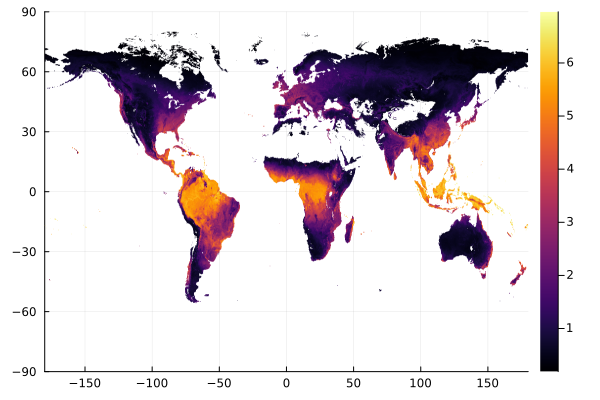

In [22]:
myplot(medians[variable = "terrestrial"])

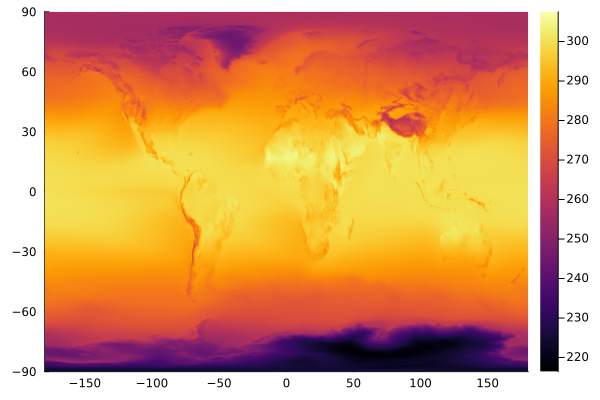

In [23]:
myplot(medians[variable = "air"])

Let's make a slightly more complex computation to demonstrate a case where multiple outputs are generated. For examples, imagine we want to normalize every time series (to zero mean and unit variance), but at the same time return the means and variances in a single dataset for later re-use:

In [24]:
function norm(ts_out, mean_out, std_out, ts_in)
    tsshort = filter(!isnan,ts_in)
    if isempty(tsshort)
        ts_out .= missing
        mean_out[] = missing
        std_out[] = missing
    else
        mean_out[] = mean(tsshort)
        std_out[] = std(tsshort)
        ts_out .= (ts_in .- mean_out[])./std_out[]
    end
end
indims = InDims("Time")
od_ts = OutDims("Time",path = "./normalized_ts.zarr",backend=:zarr,overwrite=true)
od_m = OutDims(path = "./means.nc",backend=:netcdf, overwrite=true)
od_s = OutDims(path = "./stds.nc",backend=:netcdf, overwrite=true)
outdims = (od_ts, od_m, od_s)
tsnorm, means, stds = mapCube(norm,c,indims=indims, outdims=outdims)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


(YAXArray with the following dimensions
time                Axis with 1748 Elements from 1980-01-05T00:00:00 to 2017-12-31T00:00:00
lon                 Axis with 1440 Elements from -179.875 to 179.875
lat                 Axis with 720 Elements from 89.875 to -89.875
Variable            Axis with 5 elements: air_temperature_2m land_surface_temperature gross_primary_productivity terrestrial_ecosystem_respiration net_ecosystem_exchange 
Total size: 33.76 GB
, YAXArray with the following dimensions
lon                 Axis with 1440 Elements from -179.875 to 179.875
lat                 Axis with 720 Elements from 89.875 to -89.875
Variable            Axis with 5 elements: air_temperature_2m land_surface_temperature gross_primary_productivity terrestrial_ecosystem_respiration net_ecosystem_exchange 
Total size: 19.78 MB
, YAXArray with the following dimensions
lon                 Axis with 1440 Elements from -179.875 to 179.875
lat                 Axis with 720 Elements from 89.875 to -89.8

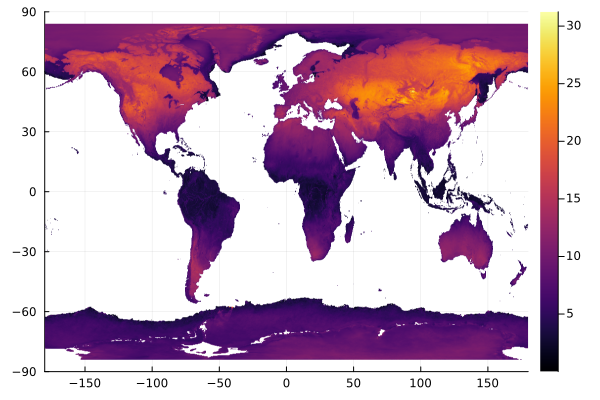

In [25]:
myplot(stds[var="land_surface"])

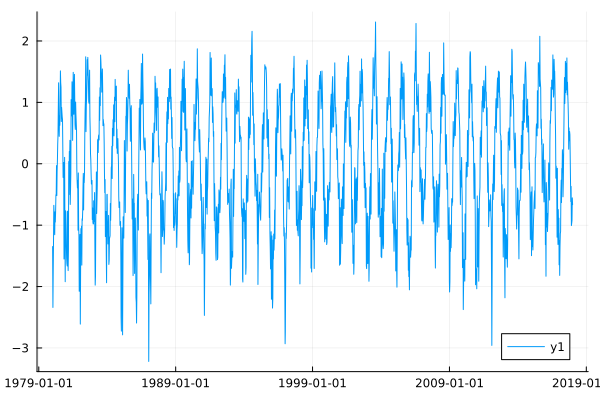

In [26]:
plot(tsnorm.time,tsnorm[lon=11,lat=51,var="air"][:])

So far the function applied here were very simple statistics. Just to stress again, that we are running arbitrary Julia code here, so for example if we want to use some package for time series decomposition like `Forecast.jl`:

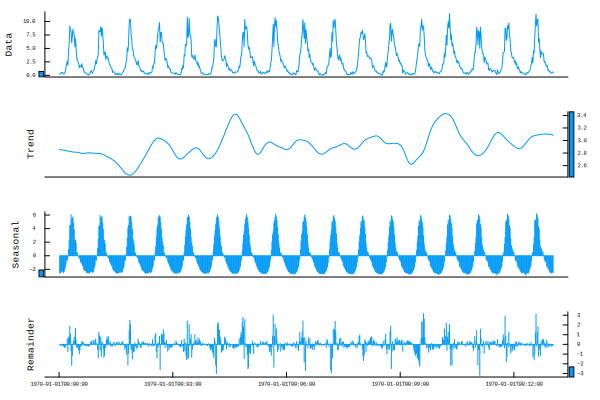

In [27]:
using Forecast
data = ds.gross_primary_productivity[time=Date(2001)..Date(2018,12,31), lon=11,lat=51][:]
stlres = stl(data,46,robust=true,verbose=false)
plot(stlres)

In order to apply this over a full array we define the usual Trio: indims, outdims and the function to be applied. Here we create a new dimension for the output. There are 2 types of axes in YAXArrays, `CategoricalAxis` for unordered and `RangeAxis` for ordered dimensions. Here we create a categorical axis for our outputs. This means that inside the function the input array `xin` is a vector with of length `n_timesteps` and the output is a matrix of size `n_timesteps x 3` 

In [15]:
import Logging
Logging.disable_logging(Logging.Info)
indims = InDims("time")
outdims = OutDims("time",CategoricalAxis("Scale",["Seasonal", "Trend", "Remainder"]), path = "decomposed.zarr",backend=:zarr, overwrite=true)
function decompose_TS(xout, xin)
    any(isnan,xin) && return xout .= missing
    stlres = stl(xin,46,robust=true,verbose=false)
    _,seas,trend,rem = eachcol(stlres.decomposition)
    xout[:,1] = seas
    xout[:,2] = trend
    xout[:,3] = rem
end
dec = mapCube(decompose_TS, 
    ds.gross_primary_productivity[time=Date(2001)..Date(2018,12,31),lon=5..20,lat=37..50],
    indims = indims,
    outdims = outdims
)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


YAXArray with the following dimensions
time                Axis with 782 Elements from 2001-01-05T00:00:00 to 2017-12-31T00:00:00
Scale               Axis with 3 elements: Seasonal Trend Remainder 
lon                 Axis with 60 Elements from 5.125 to 19.875
lat                 Axis with 52 Elements from 49.875 to 37.125
Total size: 27.92 MB


You see that the resulting array is a 4-dimensional array including the newly created axis. Lets do some plots:

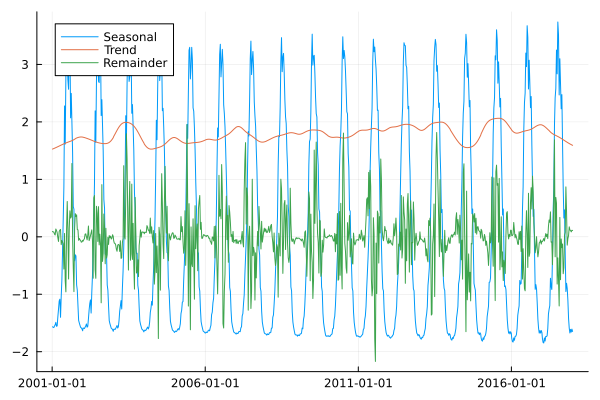

In [31]:
plot(dec.time,dec[lon=11,lat=47][:,:],label = reshape(dec.Scale,1,3))

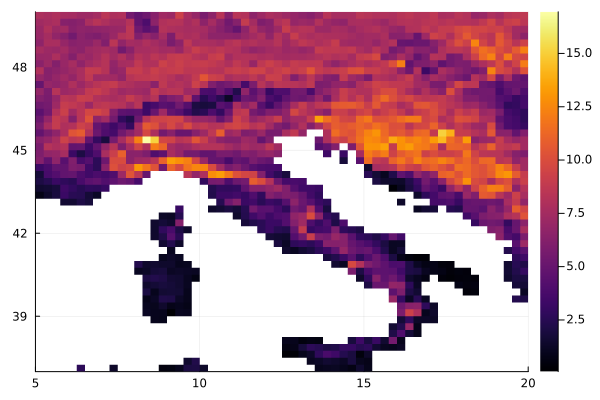

In [32]:
#Compute variance and plot a map of seasonal variance
scalevar = mapslices(var,dec,dims="Time")
myplot(scalevar[scale="Seas"])

Now you have time to try some of the map functions on your own datasets/your own methods on this dataset. Note also that there is a list of pre-defined functionality in EarthDataLab.jl, like removing and exracting seasonal cycles, normalization and more, in particular lazy methods for interpolation and aggregation. However, Currently the package is not yet compatible with GeoInterface v1, so it will lead to a downgrade and loss of functionality in Rasters.jl. 

# 3. YAXArrays table-interface

Similar to Rasters.jl, also YAXArrays provides a method to represent labelled arrays as a table. However, as everything in YAXArrays, lazy is the default as well for tables. So the CubeTable constructor will not load any data but will provide an iterator over table chunks that one can use for further analysis. Here it is guaranteed that these subtables fit into memory and they can be distributed for parallel data loading and processing

In [26]:
using Revise, YAXArrays, Zarr, Plots
ds = open_dataset("./esdc_subset2.zarr")

countryds = open_dataset("./countries.zarr")
countryds.countries.properties["labels"] = Dict(parse(Int,k)=>v for (k,v) in countryds.countries.properties["labels"])
countryds.countries.properties["Name"] = "Country"
countryds.countries

YAXArray with the following dimensions
lon                 Axis with 1440 Elements from -179.875 to 179.875
lat                 Axis with 720 Elements from 89.875 to -89.875
name: countries
labels: Dict(56 => "Vietnam", 35 => "Belarus", 60 => "Belgium", 220 => "Comoros", 67 => "Spain", 215 => "Cayman Islands", 73 => "Tunisia", 115 => "Chad", 185 => "Curaao", 86 => "Sudan"…)
Total size: 3.96 MB


In [50]:

tab = CubeTable(gpp = ds.gross_primary_productivity, tair = ds.air_temperature_2m, country = countryds.countries)


Datacube iterator with 80 subtables with fields: (:gpp, :tair, :country, :lon, :lat, :time)

It is possible to loop over or index into a table iterator to get one of the subtables or . Note that even here nothing is loaded yet. 

In [51]:
subtab = tab[42]

Table chunk with schema:
Tables.Schema:
 :gpp      Float32
 :tair     Float32
 :country  Union{Missing, Int32}
 :lon      Float64
 :lat      Float64
 :time     DateTime

Only when accessing a specific column, the data is actually loaded

In [52]:
subtab.tair

23846400-element YAXArrays.DAT.YAXColumn{Float32, YAXArrays.YAXTools.PickAxisArray{Float32, 3, Array{Float32, 3}, (1, 2, 3), nothing}, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}}:
 243.80823
 243.77553
 243.4129
 243.15944
 243.27448
 243.25552
 243.31468
 243.88727
 244.36066
 244.89609
 245.5151
 246.1368
 246.0644
   ⋮
 278.0348
 278.06662
 278.1073
 278.1566
 278.20862
 278.2735
 278.3511
 278.41074
 278.46765
 278.52176
 278.5911
 278.65143

But since a subtable implements the Tables interface we can also convert to a DataFrame

In [53]:
using DataFrames
DataFrame(subtab)

,gpp,tair,country,lon,lat,time
,Float32,Float32,Int32?,Float64,Float64,DateTime
1,NaN,243.808,48,-179.875,67.375,2000-01-05T00:00:00
2,NaN,243.776,48,-179.625,67.375,2000-01-05T00:00:00
3,NaN,243.413,48,-179.375,67.375,2000-01-05T00:00:00
4,NaN,243.159,48,-179.125,67.375,2000-01-05T00:00:00
5,NaN,243.274,48,-178.875,67.375,2000-01-05T00:00:00
6,NaN,243.256,48,-178.625,67.375,2000-01-05T00:00:00
7,NaN,243.315,48,-178.375,67.375,2000-01-05T00:00:00
8,NaN,243.887,48,-178.125,67.375,2000-01-05T00:00:00
9,NaN,244.361,48,-177.875,67.375,2000-01-05T00:00:00


These tables can be used for aggregating data. Suppose we want to compute the mean temperature by country, YAXArrays provides some tools to do this in connection with OnlineStats.jl and WeightedOnlineStats.jl

In [42]:
using WeightedOnlineStats, OnlineStats
using Distributed
addprocs(8)

8-element Vector{Int64}:
 2
 3
 4
 5
 6
 7
 8
 9

In [54]:
@everywhere begin
    using Pkg
    Pkg.activate(".")
    using YAXArrays, Zarr, Plots, WeightedOnlineStats, OnlineStats, Dates
end

      From worker 4:	  Activating project at `~/Desktop/JuliaEO/Handson`
      From worker 5:	  Activating project at `~/Desktop/JuliaEO/Handson`
      From worker 6:	  Activating project at `~/Desktop/JuliaEO/Handson`
      From worker 2:	  Activating project at `~/Desktop/JuliaEO/Handson`
      From worker 9:	  Activating project at `~/Desktop/JuliaEO/Handson`
      From worker 3:	  Activating project at `~/Desktop/JuliaEO/Handson`
      From worker 7:	  Activating project at `~/Desktop/JuliaEO/Handson`
      From worker 8:	  Activating project at `~/Desktop/JuliaEO/Handson`


  Activating project at `~/Desktop/JuliaEO/Handson`


In [55]:
@time r = cubefittable(tab, WeightedMean, :tair, by=(:country,),weight=(r->cosd(r.lat)))

 57.234918 seconds (888.75 k allocations: 46.934 MiB, 0.31% compilation time)


YAXArray with the following dimensions
countries           Axis with 212 elements: Vietnam Belarus .. United States of America Kosovo 
Total size: 1.66 KB


In [56]:
DataFrame(first(CubeTable(mtemp = r)))

,mtemp,countries
,Float64?,String
1,296.754,Vietnam
2,279.939,Belarus
3,283.315,Belgium
4,298.076,Comoros
5,286.948,Spain
6,299.779,Cayman Islands
7,293.014,Tunisia
8,299.979,Chad
9,299.769,Curaao


In [57]:
@everywhere splitmonth(r) = month(r.time)
r = cubefittable(tab, WeightedMean, :tair, by=(:country,splitmonth),weight=(r->cosd(r.lat)))

YAXArray with the following dimensions
countries           Axis with 212 elements: Vietnam Belarus .. United States of America Kosovo 
Category2           Axis with 12 elements: 1 2 .. 11 12 
Total size: 19.88 KB


In [58]:
rmprocs(workers())

Task (done) @0x00007fcb6b356e10